<a href="https://colab.research.google.com/github/aderdouri/ActuarialThesis/blob/master/Notebooks/Regressors/myLightGBMRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Régréssion LightGBM

## Cloner la branche contenant le dataset et le code qui va avec.

In [ ]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 868, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 868 (delta 71), reused 110 (delta 40), pack-reused 717
Receiving objects: 100% (868/868), 123.29 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (361/361), done.
total 96
drwxr-xr-x 2 root root  4096 Oct 26 10:47 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root  4096 Oct 26 10:47 AllstateClaimsSeverity/
drwxr-xr-x 2 root root  4096 Oct 26 10:47 Data/
drwxr-xr-x 2 root root  4096 Oct 26 10:47 EMTboost/
drwxr-xr-x 2 root root  4096 Oct 26 10:47 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root  4096 Oct 26 10:47 Models/
drwxr-xr-x 2 root root  4096 Oct 26 10:47 Plots/
drwxr-xr-x 2 root root  4096 Oct 26 10:47 Notebooks/
drwxr-xr-x 2 root root  4096 Oct 26 10:47 src/
-rw-r--r-- 1 root root    54 Oct 26 10:47 README.md
-rw-r--r-- 1 root root 19545 Oct 26 10:47 myXGBoostRegressor.ipynb
-r

In [ ]:
!mkdir ActuarialThesis/plots_rgr
!ls -ltr ActuarialThesis/plots_rgr

total 0


In [ ]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [ ]:
import installHelper

In [ ]:
# Installer les packages nécéssaires
%time installHelper.installALL()

CPU times: user 344 ms, sys: 53.4 ms, total: 397 ms
Wall time: 1min 50s


In [ ]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


In [ ]:
# Importer les packages nécéssaires
from helper import *

In [ ]:
# Appliquer le theme par défaut
#sns.set_theme()

## Partir du dataset déjé encodé.

In [ ]:
# Partir du dataset déja encodé.
df = pd.read_csv('ActuarialThesis/Data/encodedBASEAUTO.csv')
df.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR,USAGE_Prive,USAGE_PriveTrajet,USAGE_Professionnel,...,SEGM_H,SEGM_M1,SEGM_M2,GARAGE_ClosCollectif,GARAGE_GarageAutre,GARAGE_IndividuelClos,CSP_CSP_50,CSP_CSP_60,CSP_CSP_AUTRE,CHARGE
0,1.134929,1,1,-0.457663,0,-0.094064,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.134929,1,0,1.101165,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.134929,1,1,-1.813166,0,1.507343,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.134929,1,0,0.626739,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.134929,1,0,-1.203190,0,1.507343,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X = df.drop('CHARGE', axis=1)
y = df['CHARGE']

Tout d'abord, nous séparons la cible du cadre de données avec des caractéristiques (df -> X, y).

Ensuite, nous divisons les données en ensembles train/val/test dans le rapport 60:20:20. L'idée est que nous utiliserons l'ensemble train pour entraîner nos modèles, l'ensemble val pour les valider et l'ensemble test pour calculer l'erreur finale du mélange. L'ensemble de test sera donc constitué de données totalement inédites.

Pour ce faire, utilisez un train_test_split régulier de sklearn pour diviser X et y en parties train et val/test dans le ratio 60:40. Ensuite, utilisez à nouveau train_test_split, mais pour diviser la partie val/test obtenue en validation et test dans un rapport 50:50. Dans chaque application de train_test_split, utilisez random_state=13 et les autres valeurs de paramètres par défaut.

Au final, vous devriez obtenir X_train, X_val, X_test avec les formes suivantes, respectivement : (23786, 58), (7929, 58), (7929, 58). La même logique s'applique à y_train, y_val, y_test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=13)

## Option 2 of the split:

In [ ]:
# Partir du dataset déja encodé et splité en Train/Test
df_train = pd.read_csv('ActuarialThesis/Data/encodedTrainBASEAUTO.csv')
df_test = pd.read_csv('ActuarialThesis/Data/encodedTestBASEAUTO.csv')

X_train = df_train.drop('CHARGE', axis=1)
y_train = df_train['CHARGE']

X_test = df_test.drop('CHARGE', axis=1)
y_test = df_test['CHARGE']

# Split the train set into Train/Val sets: 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [ ]:
#from lightgbm import LGBMRegressor
#from lightgbm import early_stopping, log_evaluation
#from sklearn.metrics import mean_squared_error

In [ ]:
SAMPLE_RATE = 0.4
RANDOM_SEED = 1
EARLY_STOPPING_ROUND = 100
EPOCHS=10000
NUM_TRIALS = 500

In [ ]:
lgbm_rgr = LGBMRegressor(objective='regression',
                         n_estimators=200,
                         learning_rate=0.01,
                         max_depth=5,
                         random_state=13,
                         verbose=-1)

lgbm_rgr.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
             eval_metric='rmse',
             callbacks=[early_stopping(stopping_rounds=EARLY_STOPPING_ROUND),
                        log_evaluation(period=20, show_stdv=True),
             ]
        )
y_pred_lgbm_rgr = lgbm_rgr.predict(X_val)
rmse = mean_squared_error(y_val, y_pred_lgbm_rgr, squared=False)
print("RMSE: %.5f" % rmse)

Training until validation scores don't improve for 100 rounds
[20]	valid_0's rmse: 1483.48	valid_0's l2: 2.20071e+06
[40]	valid_0's rmse: 1481.19	valid_0's l2: 2.19393e+06
[60]	valid_0's rmse: 1479.86	valid_0's l2: 2.19e+06
[80]	valid_0's rmse: 1479.36	valid_0's l2: 2.18851e+06
[100]	valid_0's rmse: 1479.6	valid_0's l2: 2.18922e+06
[120]	valid_0's rmse: 1479.75	valid_0's l2: 2.18967e+06
[140]	valid_0's rmse: 1479.71	valid_0's l2: 2.18955e+06
[160]	valid_0's rmse: 1479.85	valid_0's l2: 2.18996e+06
Early stopping, best iteration is:
[79]	valid_0's rmse: 1479.33	valid_0's l2: 2.18842e+06
RMSE: 1479.32948


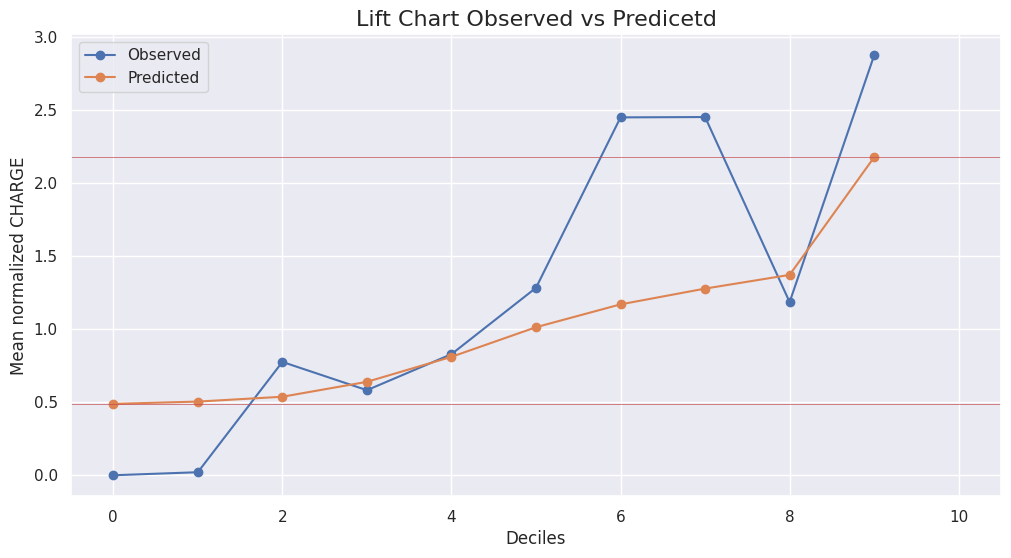

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_val, y_pred_lgbm_rgr)
plotLiftChart(df_ObsVsPred);

In [ ]:
def cross_validation_fcn(X_train, model, early_stopping_flag=False):
    """
    Performs cross-validation on a given model using KFold and returns the average
    mean squared error (MSE) score across all folds.

    Parameters:
    - X_train: the training data to use for cross-validation
    - model: the machine learning model to use for cross-validation
    - early_stopping_flag: a boolean flag to indicate whether early stopping should be used

    Returns:
    - model: the trained machine learning model
    - mean_mse: the average MSE score across all folds
    """
    mse_list = []
    for train_index, val_index in kf.split(X_train):
        # Split the data into training and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Train the model on the training set
        if early_stopping_flag:
            # Use early stopping if enabled
            model.fit(X_train_fold, y_train_fold,
                      eval_set=[(X_val_fold, y_val_fold)],
                      callbacks=[early_stopping(stopping_rounds=250, verbose=0)])
        else:
            model.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation set and calculate the MSE score
        y_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred, squared=False)
        mse_list.append(mse)

    # Return the trained model and the average MSE score
    return model, np.mean(mse_list)

In [ ]:
seed = 13
from sklearn.model_selection import KFold
n_folds = 5
# create KFold object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

In [ ]:
# define the objective function for Optuna optimization
def objective(trial):
    # set up the parameters to be optimized
    param = {
        'objective': trial.suggest_categorical('objective', ['tweedie']),
        'metric': trial.suggest_categorical('metric', ['RMSE']),
        'random_state': trial.suggest_categorical('random_state', [seed]),
        'n_estimators': trial.suggest_categorical('n_estimators', [10000]),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0,log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0,log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2,log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'num_leaves': trial.suggest_int('num_leaves', 40, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'cat_smooth': trial.suggest_int('cat_smooth', 1, 100),
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True])
    }

    if param["objective"] == "tweedie":
        param["tweedie_variance_power"] = trial.suggest_float("tweedie_variance_power", 1, 2)


    # create the LightGBM regressor with the optimized parameters
    model = LGBMRegressor(**param, verbose=-1)

    # perform cross-validation using the optimized LightGBM regressor
    model, mean_score =  cross_validation_fcn(X_train,
                                              model,
                                              early_stopping_flag=True)

    # retrieve the best iteration of the model and store it as a user attribute in the trial object
    best_iteration = model.best_iteration_
    trial.set_user_attr('best_iteration', best_iteration)

    return mean_score

In [ ]:
# Create an optimization study with Optuna library
study = optuna.create_study(direction="minimize", study_name="lgbm_opt")
# Optimize the study using a user-defined objective function, for a total of 50 trials
study.optimize(objective, n_trials=NUM_TRIALS)
#study.optimize(objective, n_trials=3)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
hp_lgbm = study.best_params
hp_lgbm["n_estimators"] = study.best_trial.user_attrs['best_iteration']

# Print the objective value and the set of hyperparameters of the best trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  500
Best trial:
  Value: 1307.2767237701962
  Params: 
    objective: tweedie
    metric: RMSE
    random_state: 13
    n_estimators: 10000
    reg_alpha: 0.22526419797625372
    reg_lambda: 0.0005017660037025761
    colsample_bytree: 0.8789442128781528
    subsample: 0.6622594582915033
    learning_rate: 0.18480913197165794
    max_depth: 4
    num_leaves: 85
    min_child_samples: 61
    cat_smooth: 97
    force_col_wise: True
    tweedie_variance_power: 1.4301760484836454


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.write_image("./ActuarialThesis/plots_rgr/myLightGBMRegressorParamImportances.pdf")
fig.show()

In [ ]:
optimized_lgbm_rgr = LGBMRegressor(**hp_lgbm, verbose=-1)
optimized_lgbm_rgr.fit(X_train, y_train)
y_pred_lgbm_rgr = optimized_lgbm_rgr.predict(X_test)

print("Best rmse:", mean_squared_error(y_pred_lgbm_rgr, y_test, squared=False))
print("R2 using LightGBM: ", r2_score(y_test, y_pred_lgbm_rgr ))

Best rmse: 1320.852610055324
R2 using LightGBM:  0.023290236922458907


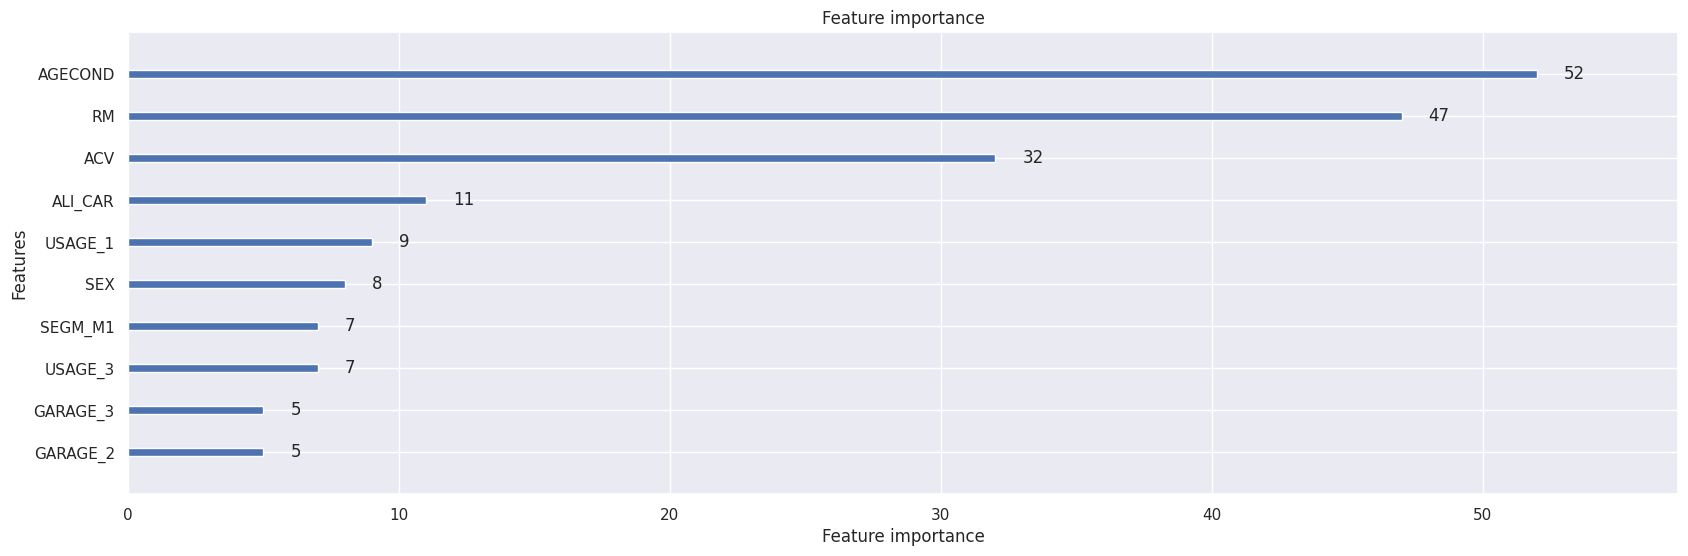

In [ ]:
from lightgbm import plot_importance
ax = plot_importance(optimized_lgbm_rgr, max_num_features=10)
ax.figure.set_size_inches(20, 6)
ax.figure.savefig('./ActuarialThesis/plots_rgr/myLightGBMRegressorFeatureImportances.pdf')

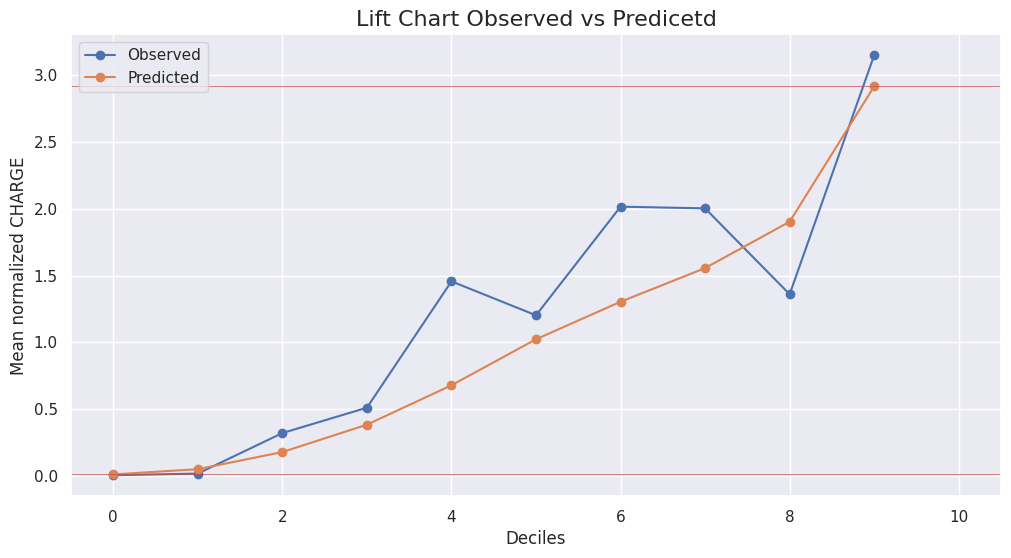

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_lgbm_rgr)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myLightGBMRegressorLiftChart.pdf')

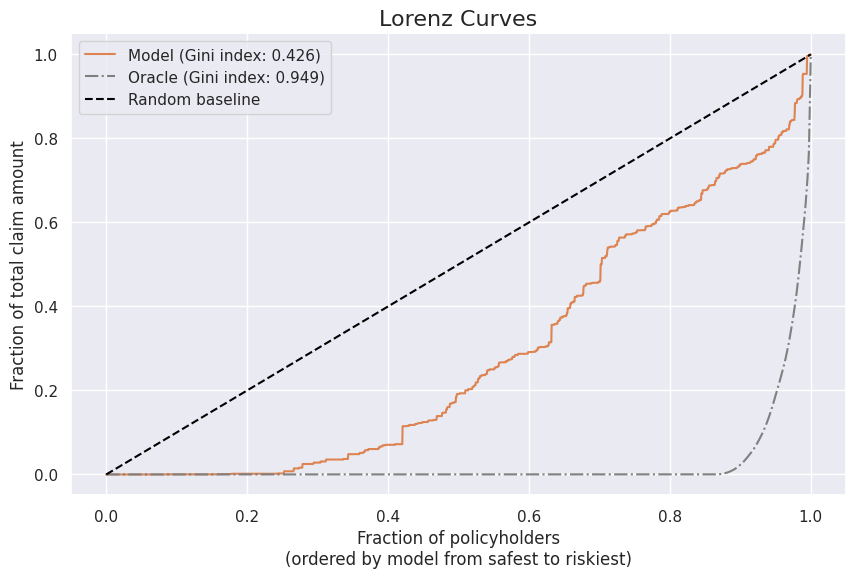

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_lgbm_rgr)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.set_size_inches(10, 6)
fig.savefig('./ActuarialThesis/plots_rgr/myLightGBMRegressorLorenzCurve.pdf')

In [ ]:
reduced_features = ['AGECOND', 'RM', 'ACV']
X_train_reduced = X_train[reduced_features]
X_val_reduced = X_val[reduced_features]

optimized_lgbm_rgr = LGBMRegressor(**hp_lgbm, verbose=-1)
optimized_lgbm_rgr.fit(X_train_reduced, y_train)
y_pred_lgbm_rgr = optimized_lgbm_rgr.predict(X_val_reduced)

print("Best rmse:", mean_squared_error(y_pred_lgbm_rgr, y_val, squared=False))
print("R2 using LightGBM: ", r2_score(y_val, y_pred_lgbm_rgr ))

Best rmse: 1482.9078285685414
R2 using LightGBM:  0.006839437859760378


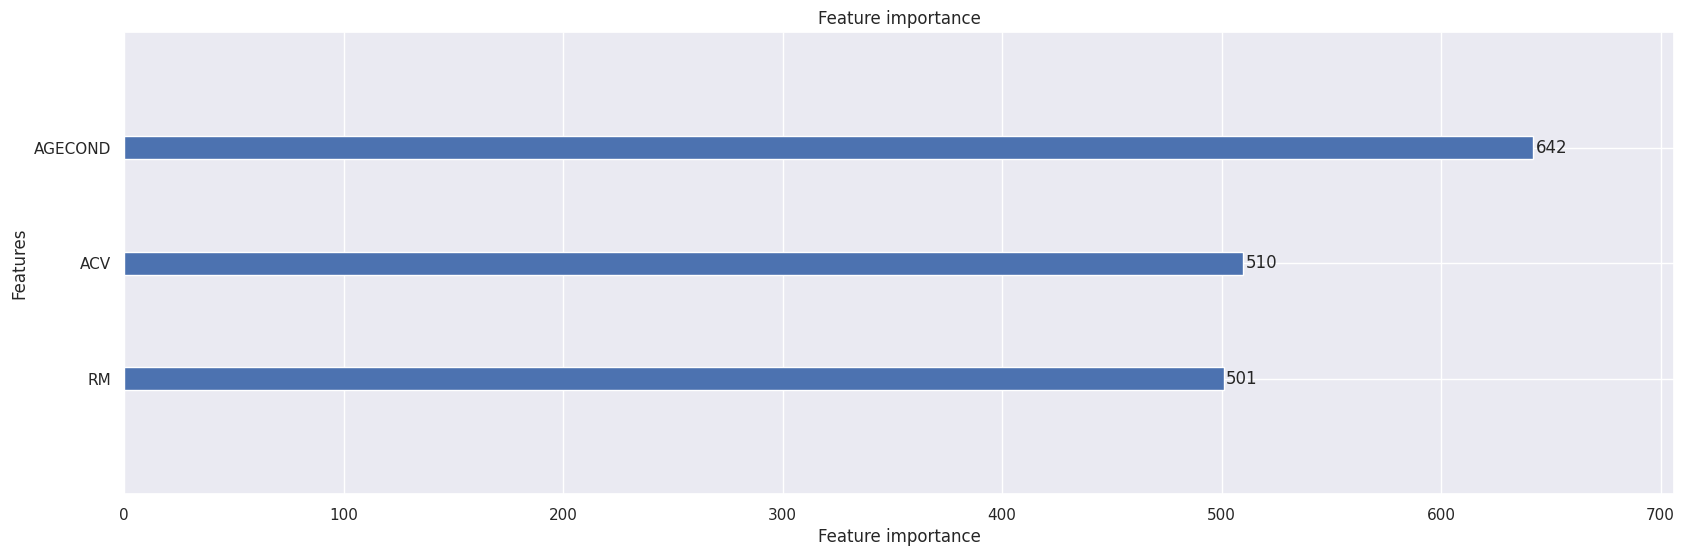

In [ ]:
from lightgbm import plot_importance
ax = plot_importance(optimized_lgbm_rgr, max_num_features=10)
ax.figure.set_size_inches(20, 6)
ax.figure.savefig('./ActuarialThesis/plots_rgr/myLightGBMRegressorFeatureImportance.pdf')

RMSE:  1318.5087572986217


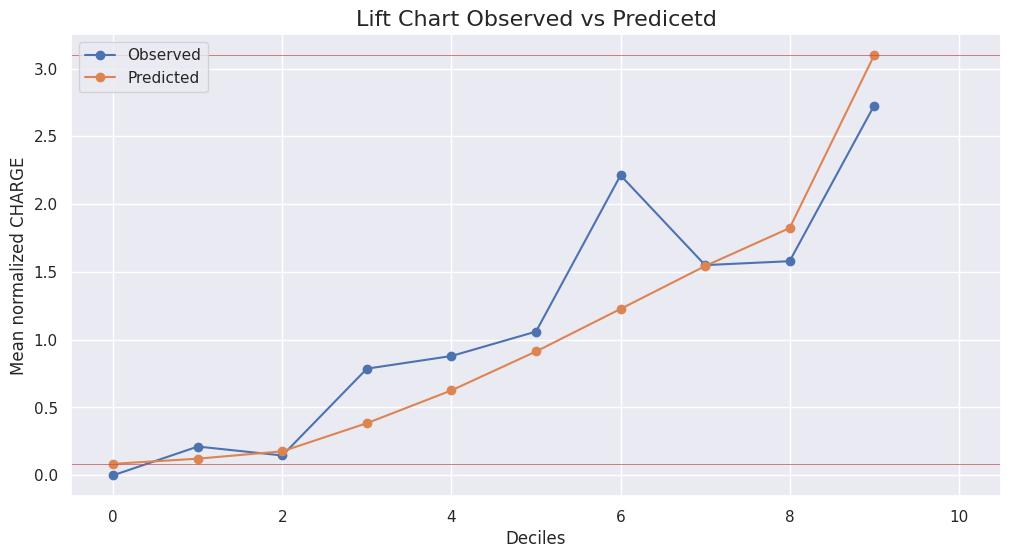

In [ ]:
y_pred_lgbm_rgr = optimized_lgbm_rgr.predict(X_test[reduced_features])
print('RMSE: ', mean_squared_error(y_test, y_pred_lgbm_rgr, squared=False))
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_lgbm_rgr)
fig, ax = plotLiftChart(df_ObsVsPred);
fig.savefig('./ActuarialThesis/plots_rgr/myLightGBMRegressorLiftChart.pdf')

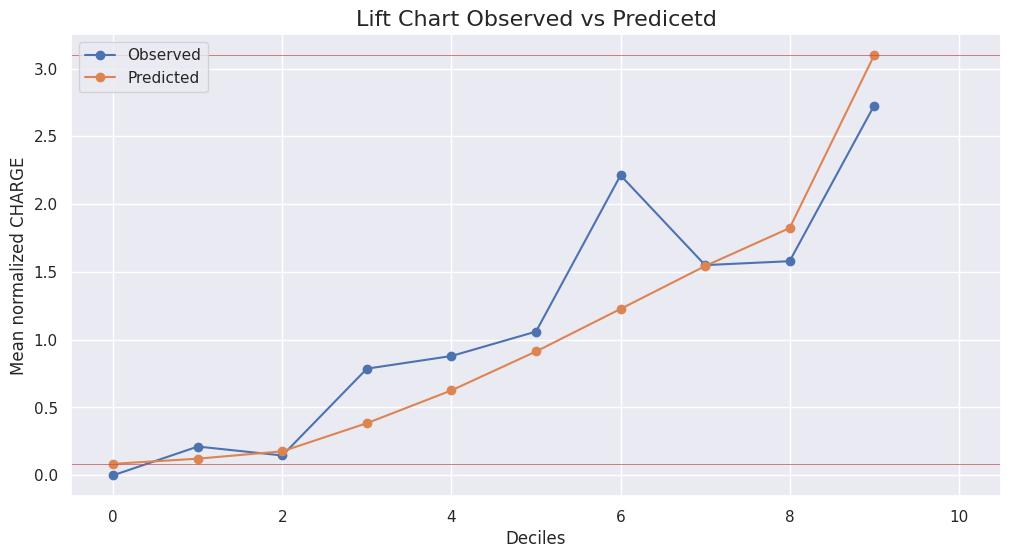

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_lgbm_rgr)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myLightGBMRegressorLiftChart.pdf')

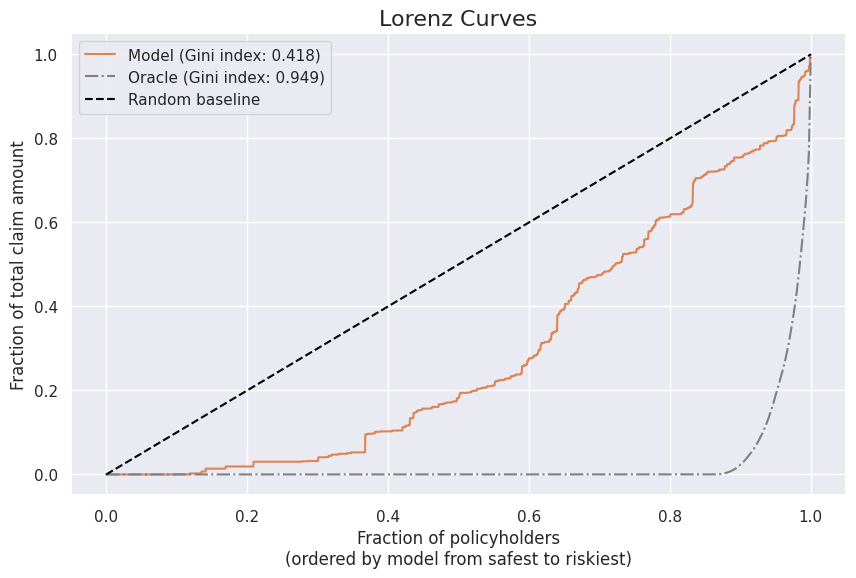

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_lgbm_rgr)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.set_size_inches(10, 6)
fig.savefig('./ActuarialThesis/plots_rgr/myLightGBMRegressorLorenzCurve.pdf')

In [ ]:
np.mean(y_test), np.mean(y_pred_lgbm_rgr)

(253.8468312450862, 206.27271342237609)

In [ ]:
np.std(y_test), np.std(y_pred_lgbm_rgr)

(1850.4171850386108, 157.23744430389505)